Processing test_image_1.png...


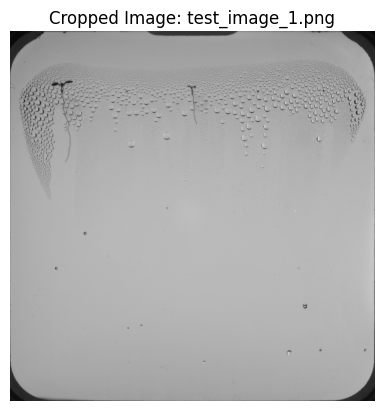

1/1 [==============================] - 0s 127ms/step


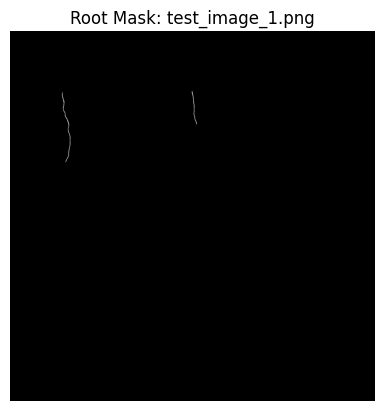

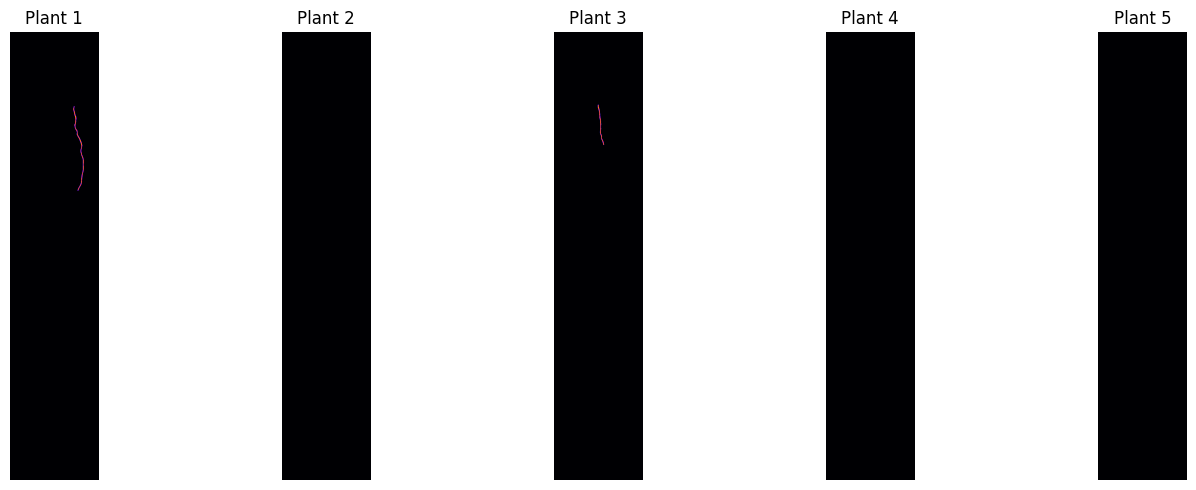

Plant 1: Primary Root Length = 515
Plant 2: Primary Root Length = 0
Plant 3: Primary Root Length = 243
Plant 4: Primary Root Length = 0
Plant 5: Primary Root Length = 0
Processing test_image_10.png...


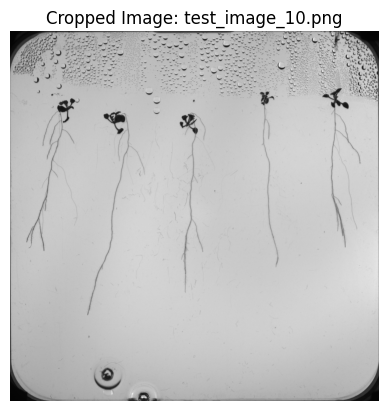

1/1 [==============================] - 0s 118ms/step


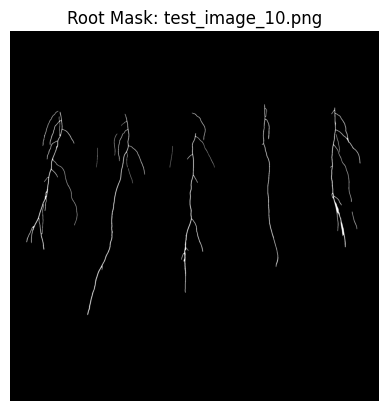

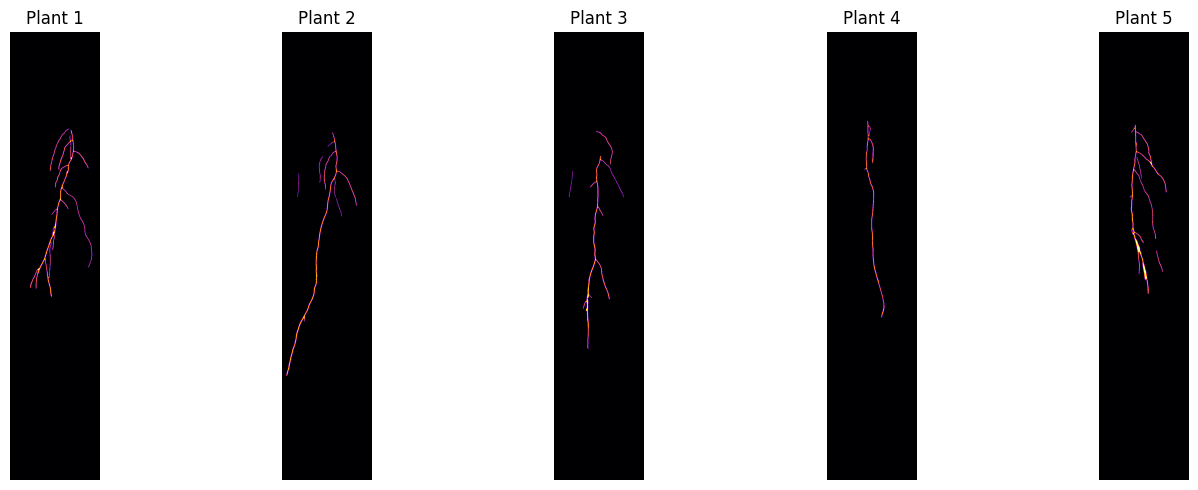

Plant 1: Primary Root Length = 268
Plant 2: Primary Root Length = 1504
Plant 3: Primary Root Length = 225
Plant 4: Primary Root Length = 1214
Plant 5: Primary Root Length = 1045
Processing test_image_11.png...


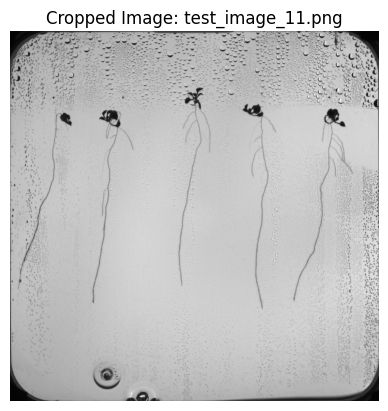

1/1 [==============================] - 0s 109ms/step


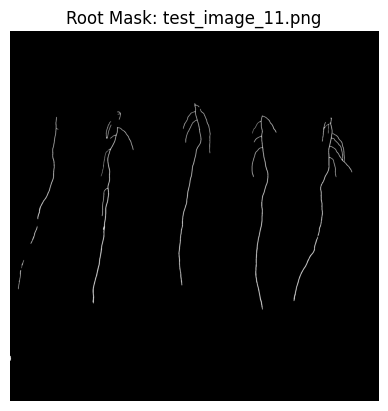

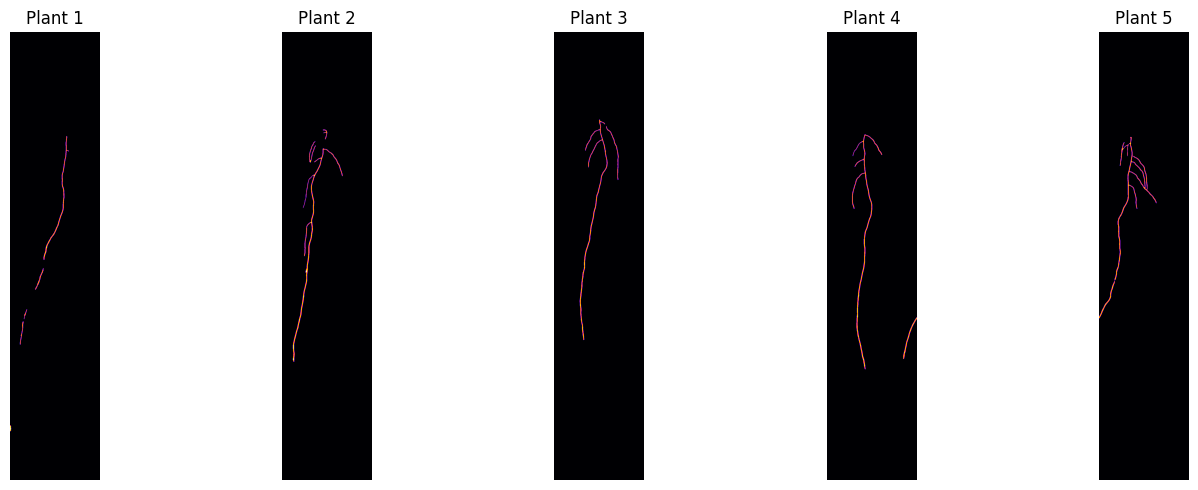

Plant 1: Primary Root Length = 763
Plant 2: Primary Root Length = 69
Plant 3: Primary Root Length = 1360
Plant 4: Primary Root Length = 1447
Plant 5: Primary Root Length = 883
Processing test_image_12.png...


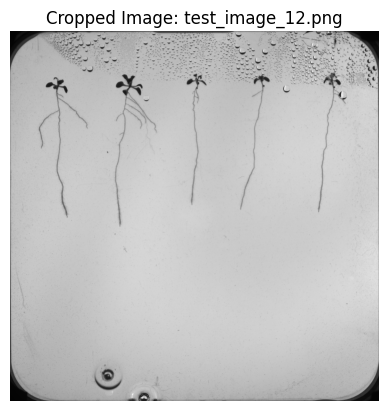

1/1 [==============================] - 0s 140ms/step


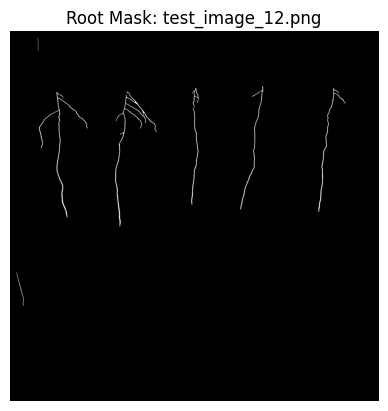

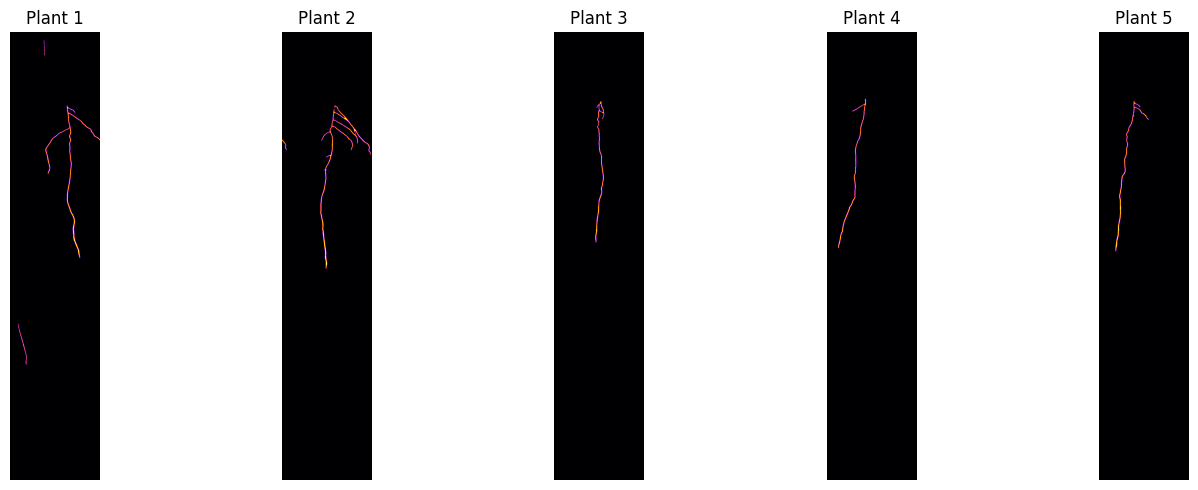

Plant 1: Primary Root Length = 94
Plant 2: Primary Root Length = 1119
Plant 3: Primary Root Length = 873
Plant 4: Primary Root Length = 922
Plant 5: Primary Root Length = 924
Processing test_image_13.png...


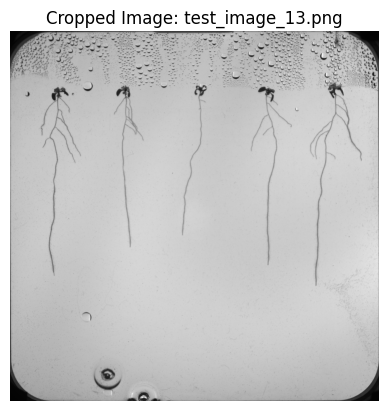

1/1 [==============================] - 0s 181ms/step


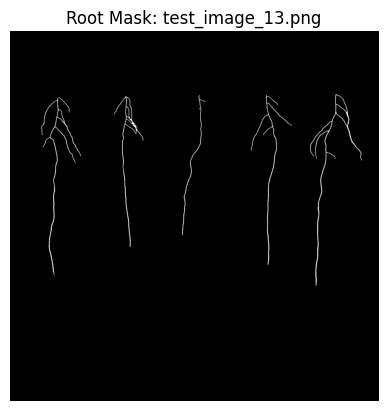

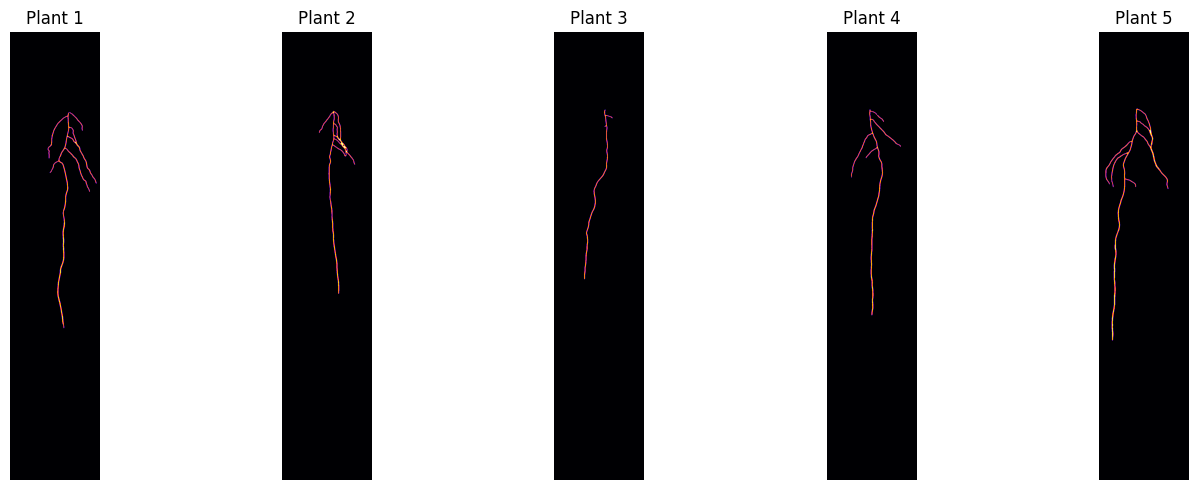

Plant 1: Primary Root Length = 119
Plant 2: Primary Root Length = 1128
Plant 3: Primary Root Length = 1047
Plant 4: Primary Root Length = 1273
Plant 5: Primary Root Length = 1431
Processing test_image_14.png...


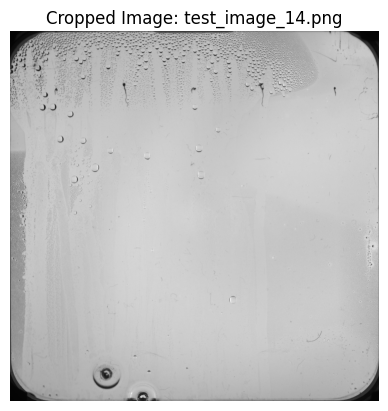

1/1 [==============================] - 0s 154ms/step


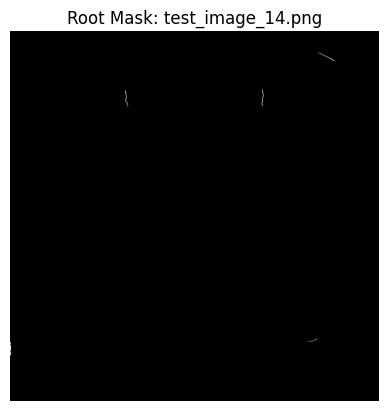

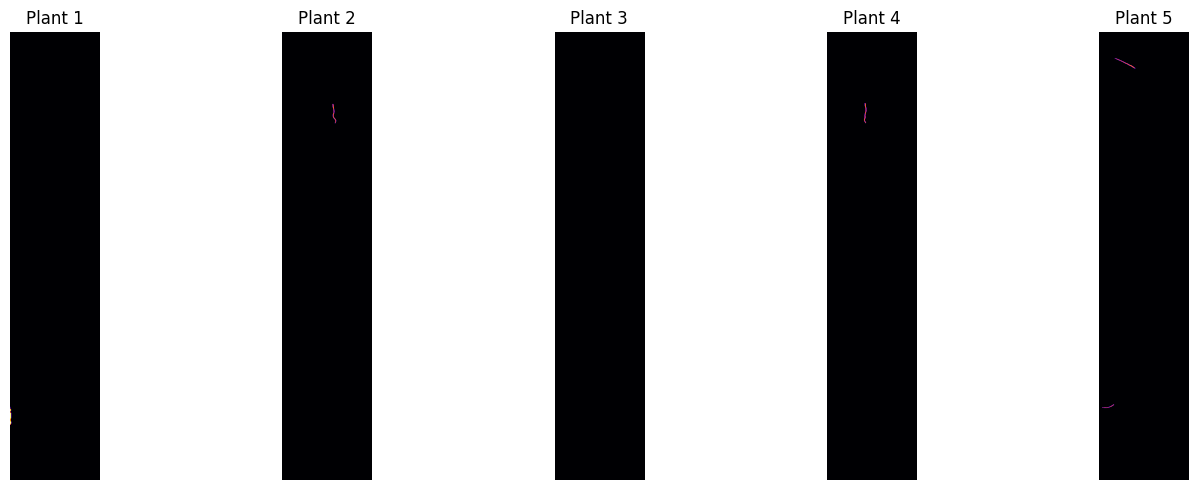

Plant 1: Primary Root Length = 110
Plant 2: Primary Root Length = 116
Plant 3: Primary Root Length = 0
Plant 4: Primary Root Length = 121
Plant 5: Primary Root Length = 127
Processing test_image_15.png...


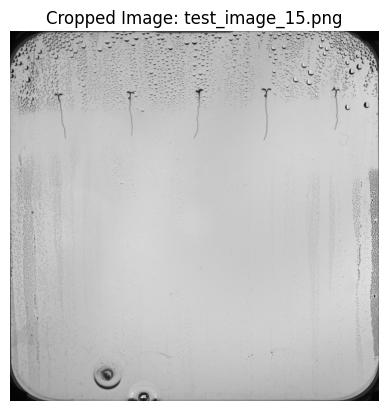

1/1 [==============================] - 0s 129ms/step


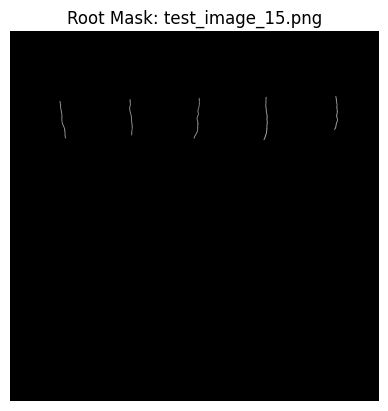

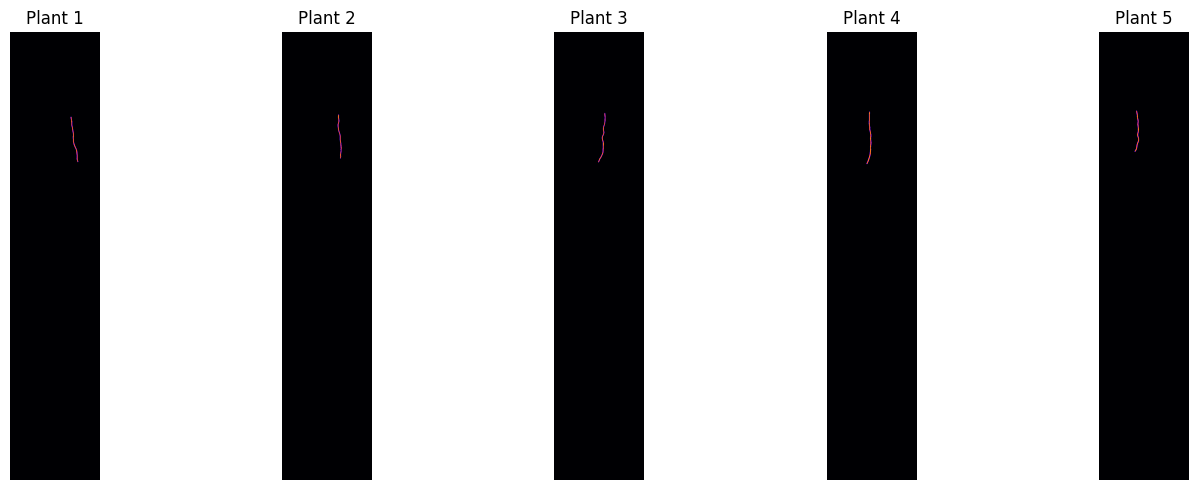

Plant 1: Primary Root Length = 276
Plant 2: Primary Root Length = 269
Plant 3: Primary Root Length = 304
Plant 4: Primary Root Length = 320
Plant 5: Primary Root Length = 251
Processing test_image_16.png...


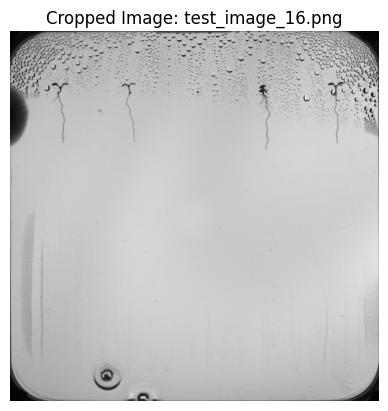

1/1 [==============================] - 0s 137ms/step


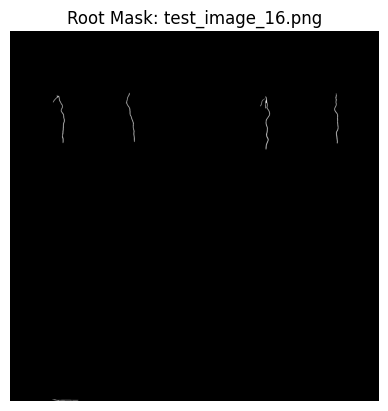

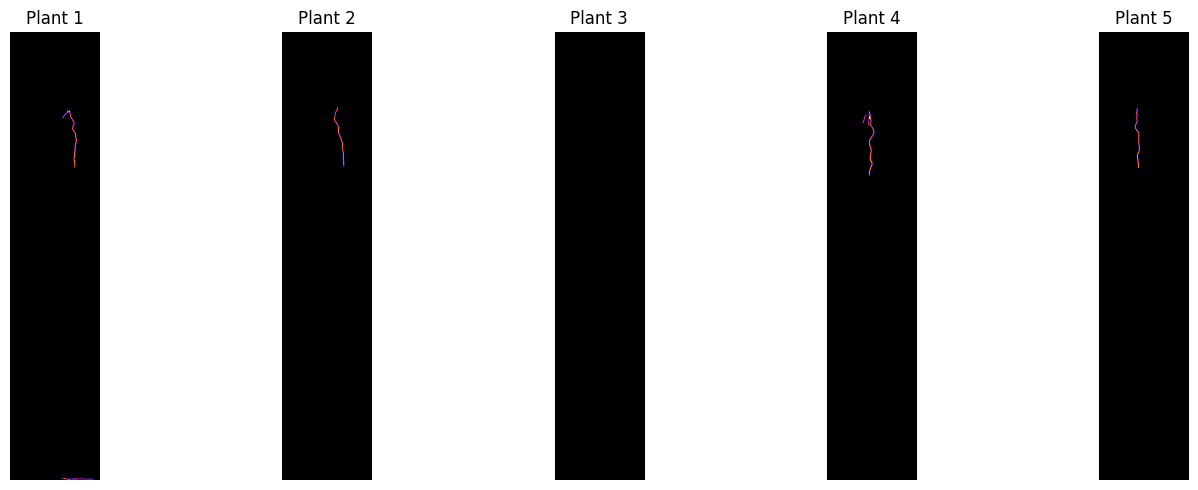

Plant 1: Primary Root Length = 370
Plant 2: Primary Root Length = 364
Plant 3: Primary Root Length = 0
Plant 4: Primary Root Length = 394
Plant 5: Primary Root Length = 373
Processing test_image_17.png...


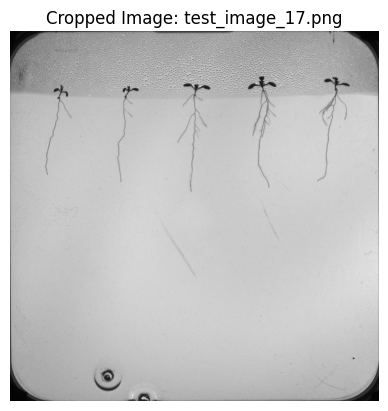

1/1 [==============================] - 0s 129ms/step


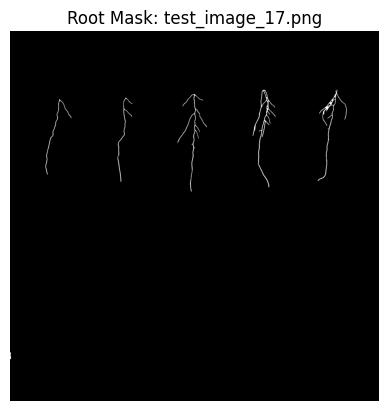

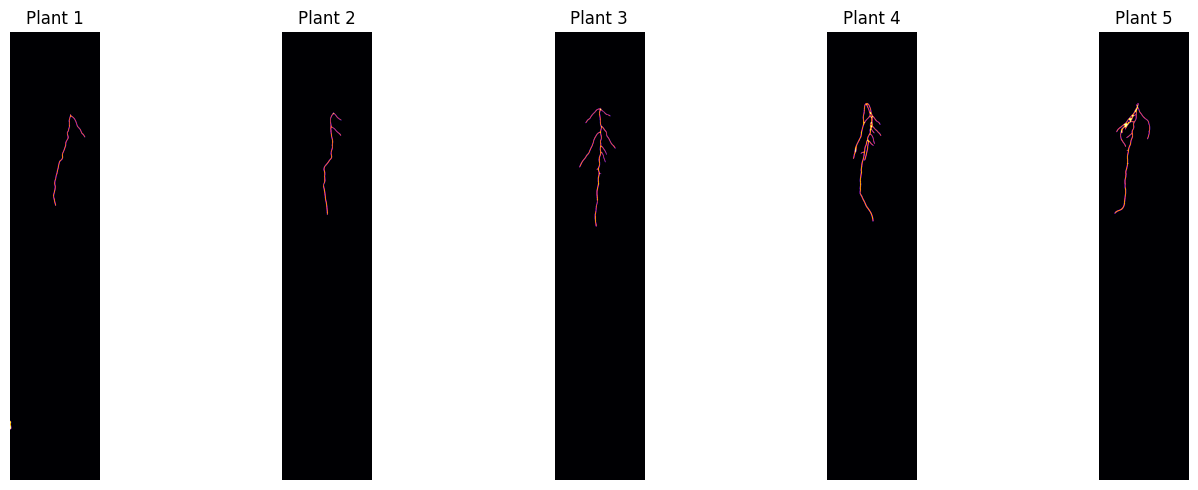

Plant 1: Primary Root Length = 563
Plant 2: Primary Root Length = 627
Plant 3: Primary Root Length = 732
Plant 4: Primary Root Length = 730
Plant 5: Primary Root Length = 702
Processing test_image_18.png...


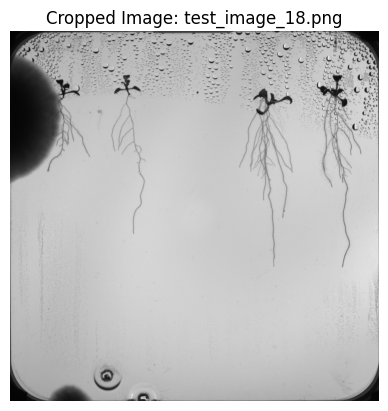

1/1 [==============================] - 0s 131ms/step


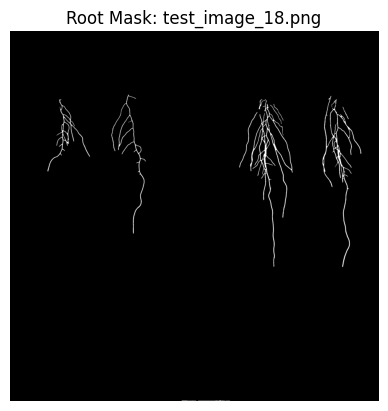

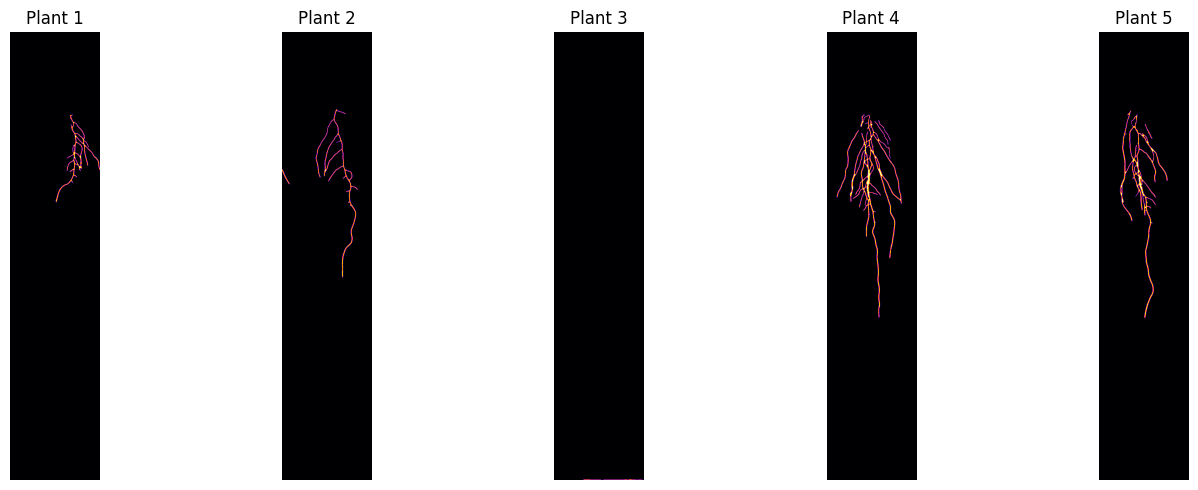

Plant 1: Primary Root Length = 563
Plant 2: Primary Root Length = 1046
Plant 3: Primary Root Length = 163
Plant 4: Primary Root Length = 1352
Plant 5: Primary Root Length = 1449
Processing test_image_2.png...


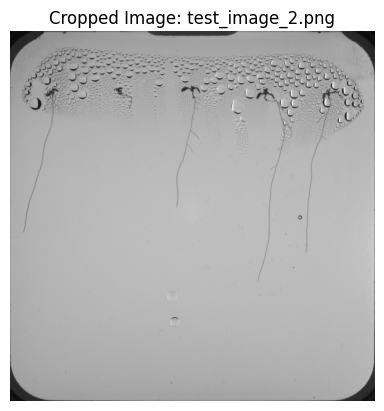

1/1 [==============================] - 0s 130ms/step


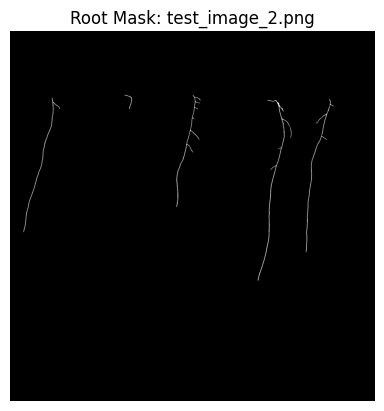

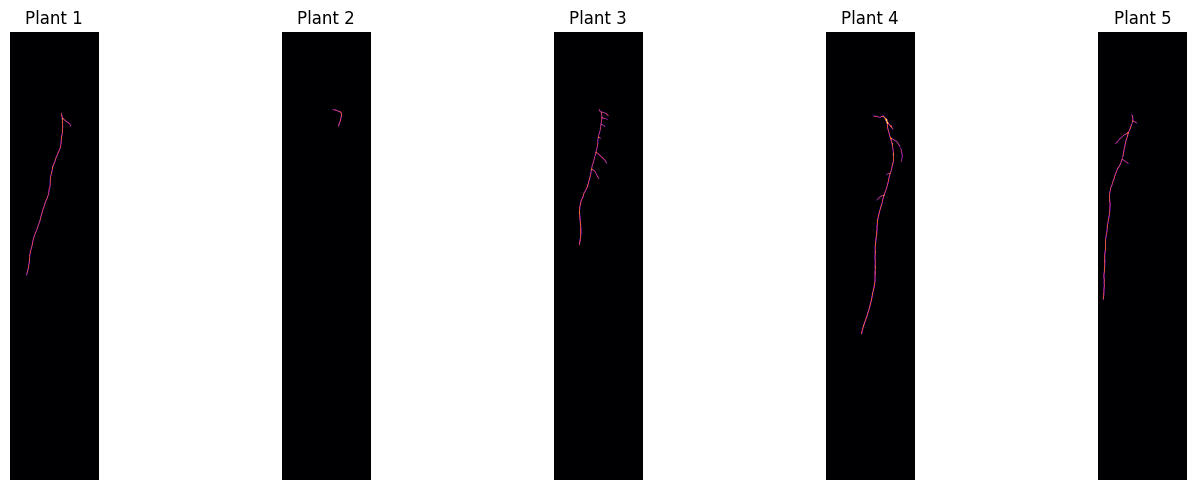

Plant 1: Primary Root Length = 993
Plant 2: Primary Root Length = 132
Plant 3: Primary Root Length = 830
Plant 4: Primary Root Length = 1394
Plant 5: Primary Root Length = 1132
Processing test_image_3.png...


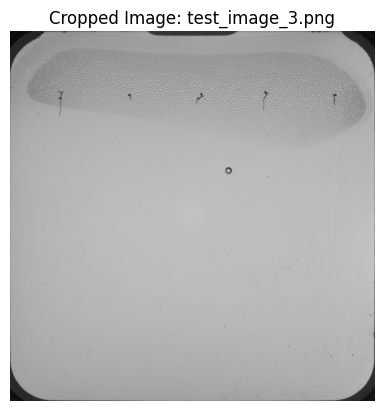

1/1 [==============================] - 0s 160ms/step


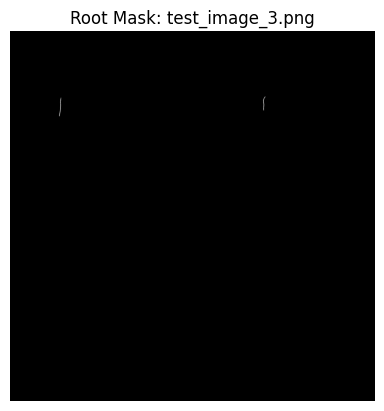

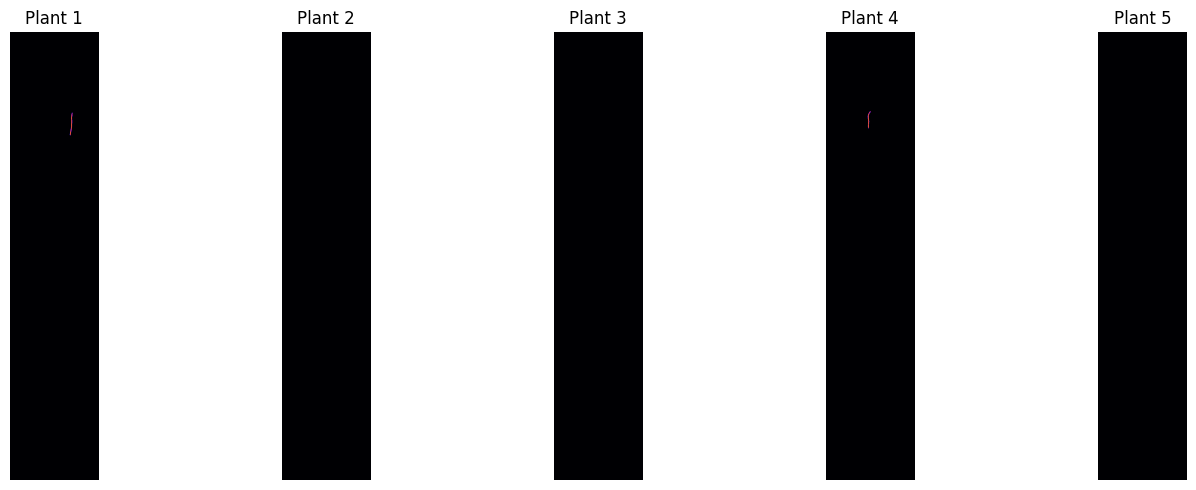

Plant 1: Primary Root Length = 135
Plant 2: Primary Root Length = 0
Plant 3: Primary Root Length = 0
Plant 4: Primary Root Length = 101
Plant 5: Primary Root Length = 0
Processing test_image_4.png...


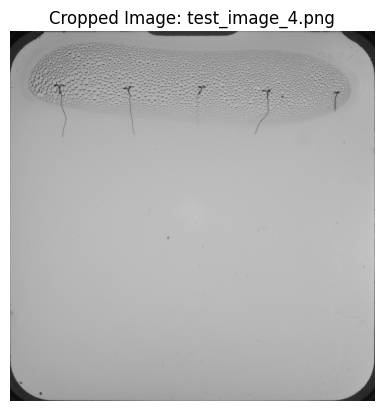

1/1 [==============================] - 0s 160ms/step


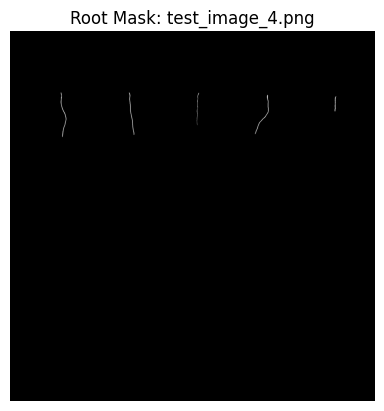

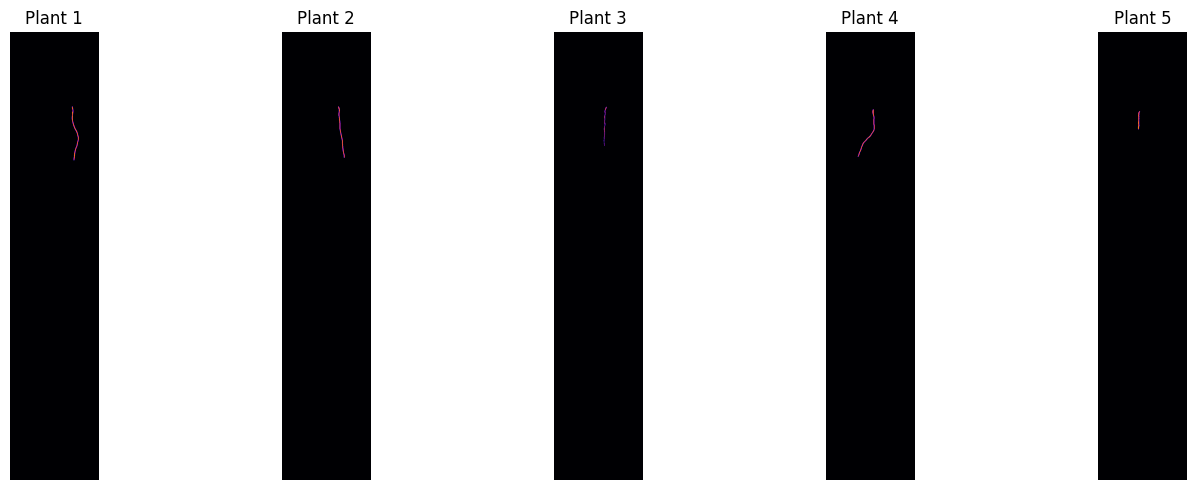

Plant 1: Primary Root Length = 329
Plant 2: Primary Root Length = 311
Plant 3: Primary Root Length = 235
Plant 4: Primary Root Length = 289
Plant 5: Primary Root Length = 111
Processing test_image_5.png...


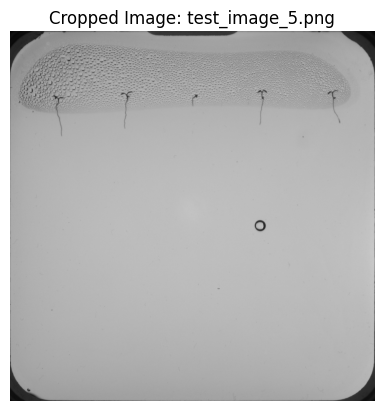

1/1 [==============================] - 0s 176ms/step


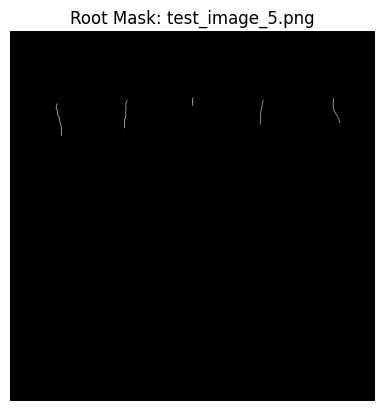

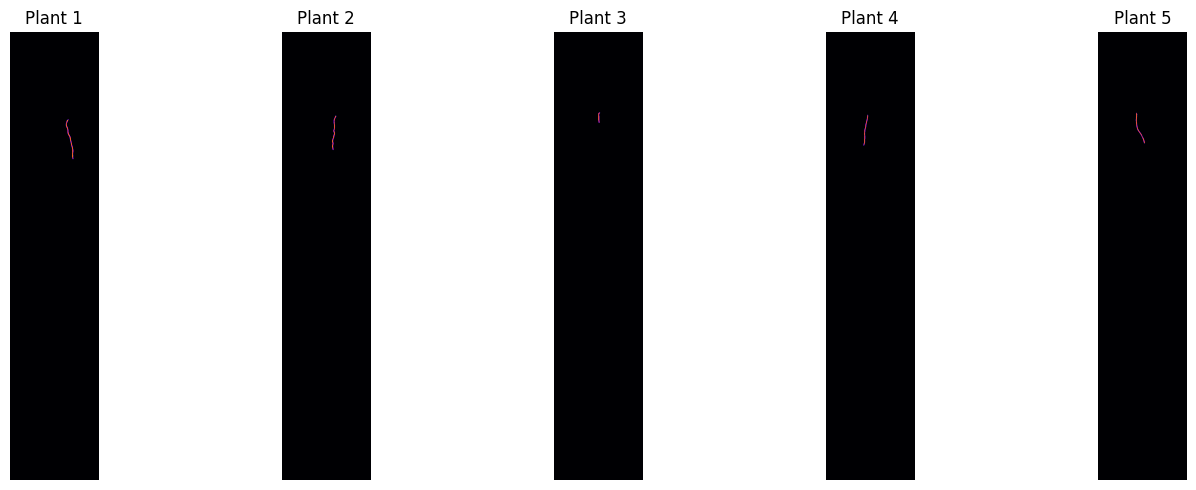

Plant 1: Primary Root Length = 242
Plant 2: Primary Root Length = 207
Plant 3: Primary Root Length = 58
Plant 4: Primary Root Length = 187
Plant 5: Primary Root Length = 183
Processing test_image_6.png...


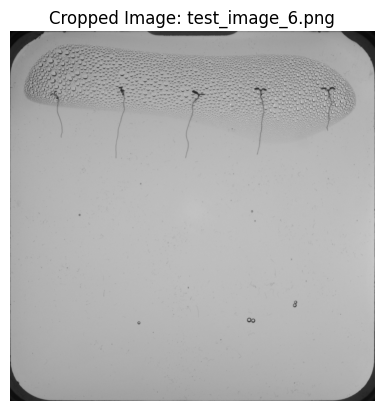

1/1 [==============================] - 0s 163ms/step


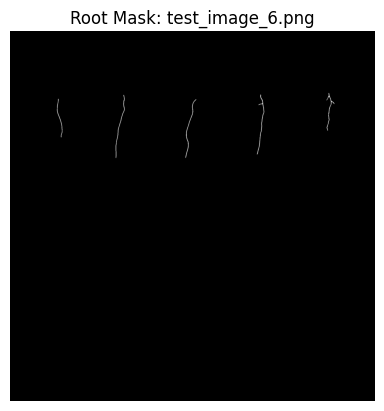

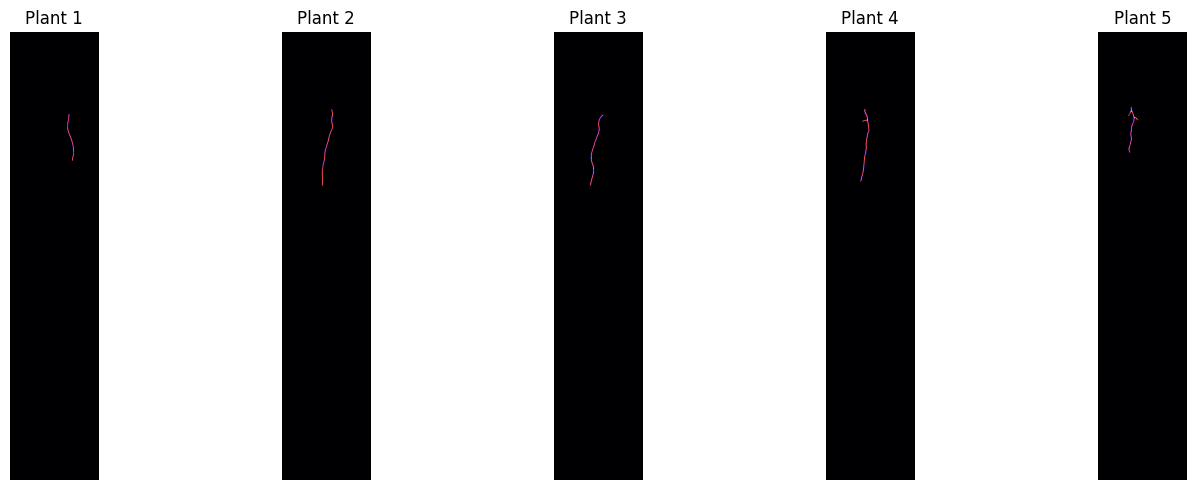

Plant 1: Primary Root Length = 282
Plant 2: Primary Root Length = 464
Plant 3: Primary Root Length = 431
Plant 4: Primary Root Length = 440
Plant 5: Primary Root Length = 276
Processing test_image_7.png...


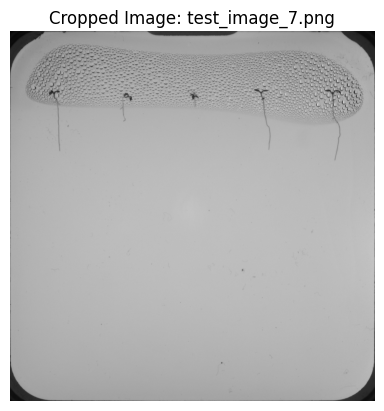

1/1 [==============================] - 0s 135ms/step


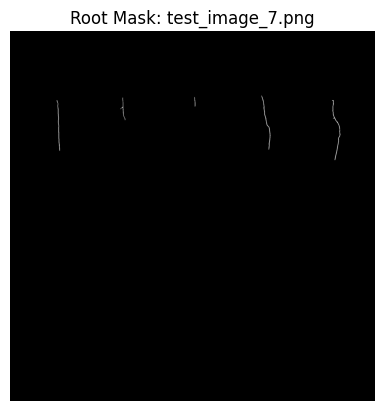

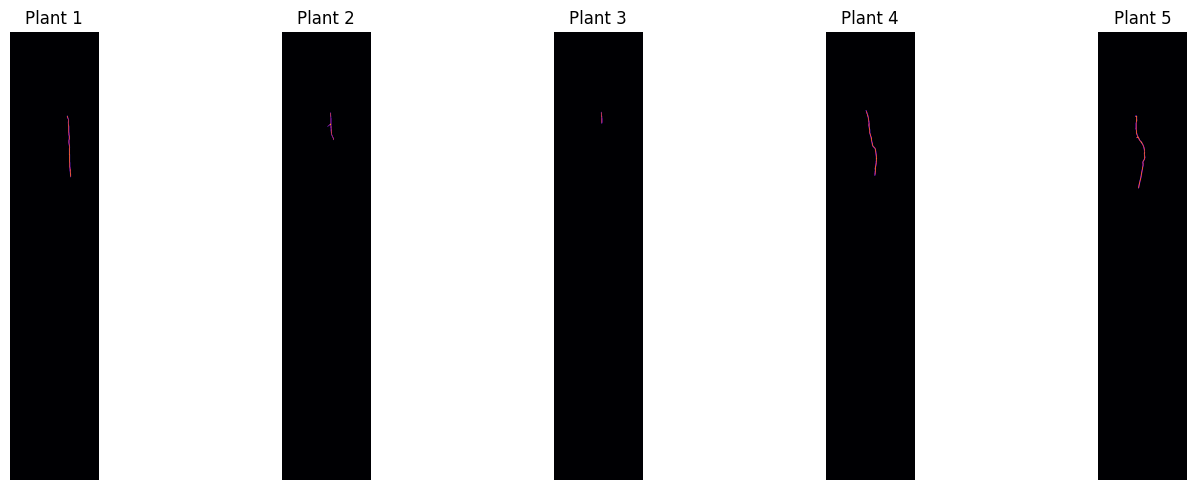

Plant 1: Primary Root Length = 372
Plant 2: Primary Root Length = 165
Plant 3: Primary Root Length = 67
Plant 4: Primary Root Length = 399
Plant 5: Primary Root Length = 445
Processing test_image_8.png...


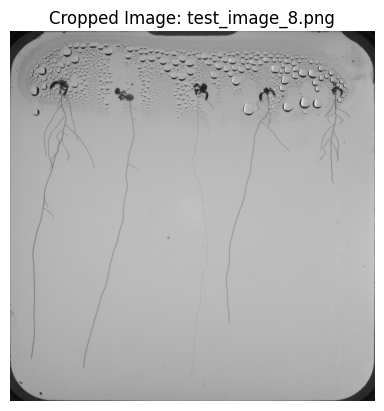

1/1 [==============================] - 0s 143ms/step


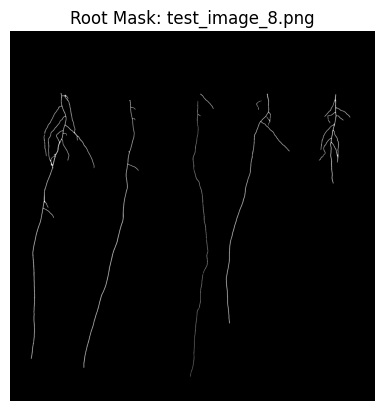

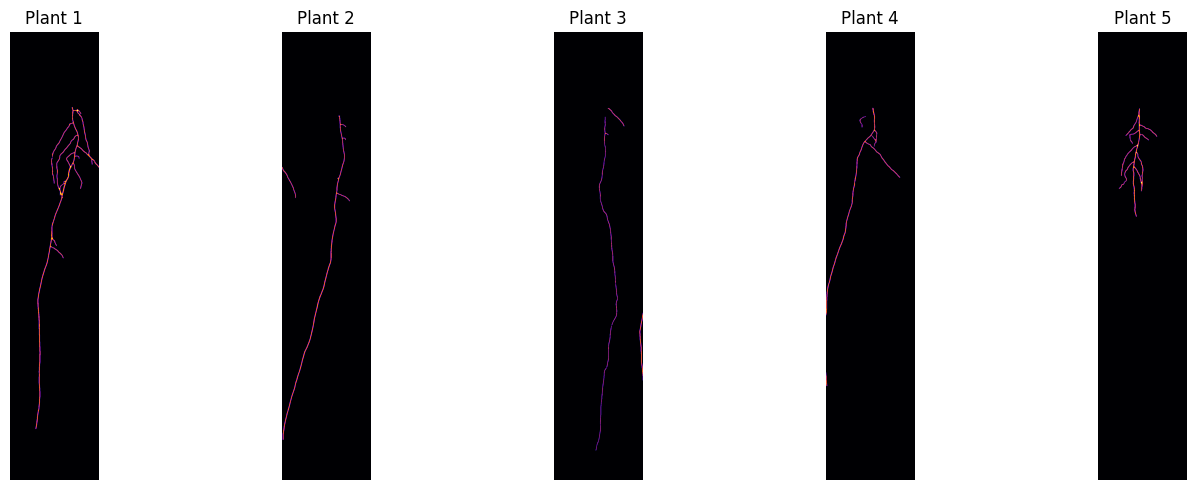

Plant 1: Primary Root Length = 1968
Plant 2: Primary Root Length = 1979
Plant 3: Primary Root Length = 117
Plant 4: Primary Root Length = 1271
Plant 5: Primary Root Length = 660
Processing test_image_9.png...


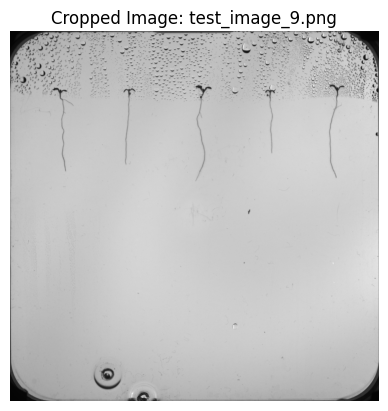

1/1 [==============================] - 0s 153ms/step


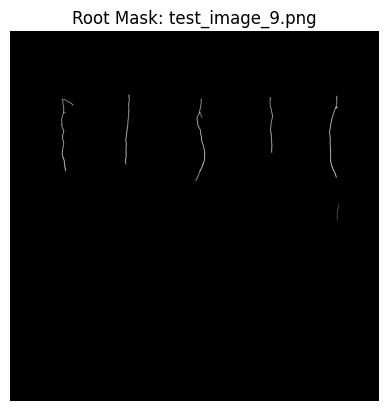

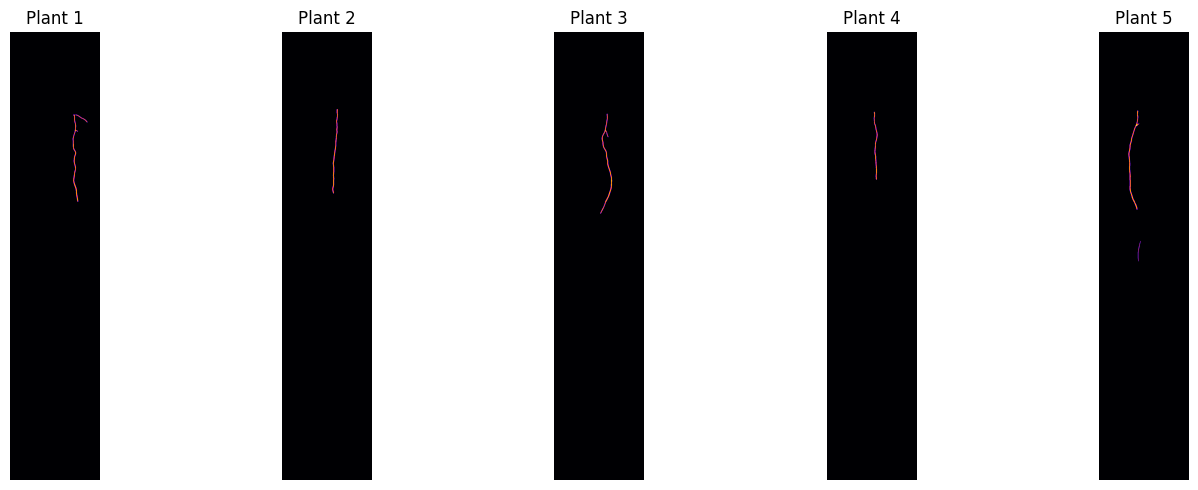

Plant 1: Primary Root Length = 540
Plant 2: Primary Root Length = 517
Plant 3: Primary Root Length = 615
Plant 4: Primary Root Length = 416
Plant 5: Primary Root Length = 608


In [49]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from skimage.morphology import skeletonize, remove_small_objects, binary_closing
import networkx as nx
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify

# Constants
patch_size = 256
model_path = "artjom_234535_unet_model_256px.h5"  # Replace with actual model file
test_images_dir = "Kaggle"  # Directory containing test images
output_csv = "sample_submission.csv"

# Load the trained model
model = load_model(model_path, custom_objects={"f1": lambda y_true, y_pred: y_true})

# Helper Functions
def full_remove_black_borders(image):
    """
    Fully removes black borders around the Petri dish image, ensuring no black edges remain.

    Args:
        image (numpy array): Input raw image.

    Returns:
        cropped_image (numpy array): Cropped image without black borders.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found.")
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped_image = image[y:y + h, x:x + w]
    return cropped_image

def clean_mask(mask):
    """
    Cleans the mask using adaptive morphological operations to reduce noise and preserve roots.

    Args:
        mask (numpy array): Input binary mask.

    Returns:
        cleaned_mask (numpy array): Cleaned binary mask.
    """
    mask = remove_small_objects(mask > 0, min_size=200)  # Remove small noise
    mask = binary_closing(mask, footprint=np.ones((5, 5)))  # Close small gaps
    return (mask > 0).astype(np.uint8)

def segment_roots(image, model):
    h, w, _ = image.shape
    pad_h = (patch_size - h % patch_size) % patch_size
    pad_w = (patch_size - w % patch_size) % patch_size
    padded_image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
    dish_patches = patchify(padded_image, (patch_size, patch_size, 3), step=patch_size)
    predicted_patches = []
    for i in range(dish_patches.shape[0]):
        for j in range(dish_patches.shape[1]):
            patch = dish_patches[i, j, 0]
            patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)  # Convert RGB to grayscale
            patch = patch / 255.0  # Normalize the patch
            patch = np.expand_dims(patch, axis=(0, -1))  # Match model input shape
            prediction = model.predict(patch)
            predicted_patches.append(prediction[0, :, :, 0])
    predicted_patches = np.array(predicted_patches)
    predicted_patches = predicted_patches.reshape(dish_patches.shape[0], dish_patches.shape[1], patch_size, patch_size)
    predicted_mask = unpatchify(predicted_patches, padded_image.shape[:2])
    cleaned_mask = clean_mask((predicted_mask > 0.5).astype(np.uint8))  # Binarize and clean mask
    return cleaned_mask[:h, :w]

def extract_individual_roots(mask, image_width):
    """
    Extracts exactly 5 root masks corresponding to the 5 plant positions.

    Args:
        mask (numpy array): Binary mask of roots.
        image_width (int): Width of the original image.

    Returns:
        individual_roots (list): List of binary masks for individual roots.
    """
    plant_width = image_width // 5
    individual_roots = []
    for i in range(5):
        x_start = i * plant_width
        x_end = (i + 1) * plant_width
        plant_mask = mask[:, x_start:x_end]
        individual_roots.append(plant_mask)
    return individual_roots

def extract_primary_root(mask):
    """
    Extracts the primary root length using skeletonization and graph-based longest path.

    Args:
        mask (numpy array): Binary mask of a single root.

    Returns:
        primary_length (float): Length of the primary root in pixels.
    """
    skeleton = skeletonize(mask > 0)
    coords = np.column_stack(np.nonzero(skeleton))
    if len(coords) == 0:
        return 0  # No primary root
    G = nx.Graph()
    coord_to_node = {tuple(coord): idx for idx, coord in enumerate(coords)}
    for coord in coords:
        y, x = coord
        G.add_node(coord_to_node[tuple(coord)], coord=(y, x))
        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
            neighbor = (y + dy, x + dx)
            if neighbor in coord_to_node:
                G.add_edge(coord_to_node[tuple(coord)], coord_to_node[neighbor])
    start_node = min(G.nodes, key=lambda n: G.nodes[n]["coord"][0])
    lengths, paths = nx.single_source_dijkstra(G, start_node)
    end_node = max(lengths, key=lengths.get)
    return lengths[end_node]

# Pipeline
predictions = []
for image_name in sorted(os.listdir(test_images_dir)):
    if image_name.endswith(".png"):
        image_path = os.path.join(test_images_dir, image_name)
        original_image = cv2.imread(image_path)
        print(f"Processing {image_name}...")

        # Step 1: Remove black borders
        cropped_image = full_remove_black_borders(original_image)
        plt.figure()
        plt.title(f"Cropped Image: {image_name}")
        plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

        # Step 2: Segment roots
        root_mask = segment_roots(cropped_image, model)
        plt.figure()
        plt.title(f"Root Mask: {image_name}")
        plt.imshow(root_mask, cmap="gray")
        plt.axis("off")
        plt.show()

        # Step 3: Extract individual roots
        individual_roots = extract_individual_roots(root_mask, cropped_image.shape[1])
        fig, axes = plt.subplots(1, len(individual_roots), figsize=(15, 5))
        for i, plant_mask in enumerate(individual_roots):
            axes[i].imshow(plant_mask, cmap="inferno")
            axes[i].axis("off")
            axes[i].set_title(f"Plant {i+1}")
        plt.tight_layout()
        plt.show()

        # Step 4: Calculate primary root lengths
        for plant_idx, plant_mask in enumerate(individual_roots, start=1):
            primary_root_length = extract_primary_root(plant_mask)
            predictions.append({
                "Plant ID": f"{image_name.split('.')[0]}_plant_{plant_idx}",
                "Length (px)": primary_root_length
            })
            print(f"Plant {plant_idx}: Primary Root Length = {primary_root_length}")

In [51]:
# Save predictions to CSV
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv(output_csv, index=False)
print(f"Predictions saved to {output_csv}")

Predictions saved to sample_submission.csv
